## Import 

In [1]:
from selenium import webdriver
from selenium_stealth import stealth
from selenium.webdriver.chrome.service import Service
from selectolax.lexbor import LexborHTMLParser
import os, json
from typing import List, Dict, Callable
import time, random, re
import pandas as pd
import requests
import io
from io import BytesIO
from io import StringIO
from bs4 import BeautifulSoup

In [2]:
def parse(parser: Callable, organic_results_data: Callable):
    '''
    Arugments:
    - parser:  Lexbor parser from scrape_google_scholar_organic_results() function.
    - organic_results_data: List to append data to. List origin location is scrape_google_scholar_organic_results() function. Line 104.
    
    This function parses data from Google Scholar Organic results and appends data to a List.
    
    It's used by scrape_google_scholar_organic_results().
    
    It returns nothing as it appends data to `organic_results_data`, 
    which appends it to `organic_results_data` List in the scrape_google_scholar_organic_results() function.
    '''
    
    for result in parser.css('.gs_r.gs_or.gs_scl'):
        try:
            title: str = result.css_first('.gs_rt').text()
        except: title = None

        try:
            title_link: str = result.css_first('.gs_rt a').attrs['href']
        except: title_link = None

        try:
            publication_info: str = result.css_first('.gs_a').text()
        except: publication_info = None

        try:
            snippet: str = result.css_first('.gs_rs').text()
        except: snippet = None

        try:
            # if Cited by is present in inline links, it will be extracted
            cited_by_link = ''.join([link.attrs['href'] for link in result.css('.gs_ri .gs_fl a') if 'Cited by' in link.text()])
        except: cited_by_link = None
        
        try:
            # if Cited by is present in inline links, it will be extracted and type cast it to integer
            cited_by_count = int(''.join([re.search(r'\d+', link.text()).group() for link in result.css('.gs_ri .gs_fl a') if 'Cited by' in link.text()]))
        except: cited_by_count = None
        
        try:
            pdf_file: str = result.css_first('.gs_or_ggsm a').attrs['href']
        except: pdf_file = None

        organic_results_data.append({
            'title': title,
            'title_link': title_link,
            'publication_info': publication_info,
            'snippet': snippet if snippet else None,
            'cited_by_link': f'https://scholar.google.com{cited_by_link}' if cited_by_link else None,
            'cited_by_count': cited_by_count if cited_by_count else None,
            'pdf_file': pdf_file
        })

def scrape_google_scholar_organic_results(
                                        query: str,
                                        pagination: bool = False,
                                        operating_system: str = 'Windows' or 'Linux',
                                        year_start: int = None,
                                        year_end: int = None,
                                        save_to_csv: bool = False, 
                                        save_to_json: bool = False
                                        ) -> List[Dict[str, str]]:
    '''
    Extracts data from Google Scholar Organic resutls page:
    - title: str
    - title_link: str
    - publication_info: str 
    - snippet: str
    - cited_by_link: str 
    - cited_by_count: int
    - pdf_file: str
    
    Arguments:
    - query: str. Search query. 
    - pagination: bool. Enables or disables pagination.
    - operating_system: str. 'Windows' or 'Linux', Checks for operating system to either run Windows or Linux verson of chromedriver
    
    Usage:
    data = scrape_google_scholar_organic_results(query='blizzard', pagination=False, operating_system='win') # pagination defaults to False 
    
    for organic_result in data:
        print(organic_result['title'])
        print(organic_result['pdf_file'])
    '''
    assert year_start and year_end
    if year_start or year_end:
        assert year_start and year_end
        assert year_start <= year_end

    # selenium stealth
    options = webdriver.ChromeOptions()
    options.add_argument('--headless')
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')
    
    options.add_experimental_option('excludeSwitches', ['enable-automation'])
    options.add_experimental_option('useAutomationExtension', False)
    
    # checks for operating system to either run Windows or Linux verson of chromedriver
    # expects to have chromedriver near the runnable file
    if operating_system is None:
        raise Exception('Please provide your OS to `operating_system` argument: "Windows" or "Linux" for script to operate.')
    
    if operating_system.lower() == 'windows' or 'win':
        driver = webdriver.Chrome(options=options, service=Service(executable_path='chromedriver.exe'))
    
    if operating_system.lower() == 'linux': 
        driver = webdriver.Chrome(options=options, service=Service(executable_path='chromedriver'))
    
    stealth(driver,
        languages=['en-US', 'en'],
        vendor='Google Inc.',
        platform='Win32',
        webgl_vendor='Intel Inc.',
        renderer='Intel Iris OpenGL Engine',
        fix_hairline=True,
    )
    
    page_num: int = 0
    organic_results_data: list = []
    
    if pagination:
        while True:
            # parse all pages
            driver.get(f'https://scholar.google.com/scholar?q={query}&hl=en&gl=us&start={page_num}&as_ylo={year_start}&as_yhi={year_end}')
            parser = LexborHTMLParser(driver.page_source)
            parse(parser=parser, organic_results_data=organic_results_data)
            
            # pagination
            if parser.css_first('.gs_ico_nav_next'):  # checks for the "Next" page button
                page_num += 10                         # paginate to the next page
                time.sleep(random.randint(1, 7))      # sleep between paginations
            else:
                break
    else:
        # parse single, first page
        driver.get(f'https://scholar.google.com/scholar?q={query}&hl=en&gl=us&start={page_num}')
        parser = LexborHTMLParser(driver.page_source)
    
        parse(parser=parser, organic_results_data=organic_results_data)
        
    if save_to_csv:
        pd.DataFrame(data=organic_results_data).to_csv('google_scholar_organic_results_data.csv', 
                                                        index=False, encoding='utf-8')
    if save_to_json:
        pd.DataFrame(data=organic_results_data).to_json('google_scholar_organic_results_data.json', 
                                                        index=False, orient='records')
    driver.quit()
    return organic_results_data

## Add target column from neuromab database

In [3]:
def AddTargetCol(df,final_df):
    '''
    Creates a list of the Target Item from the Neuromab dataframe website to append to final df
    '''     
    merged_df = final_df.merge(
        
        df[['Clone', 'Target']], left_on=['Antibody'],right_on=['Clone'], how='left'
    
    )
    merged_df = merged_df.drop('Clone', axis=1)
   
    return merged_df

## Grab Neuromab DataFrame from site

In [4]:
data_Neuromab = requests.get("https://neuromab.ucdavis.edu/catalog-download.cfm").content
df = pd.read_csv(BytesIO(data_Neuromab))

## Create URL

In [5]:
def CreateURL(query_name, TCSupe, PureID, NeuromabinQuery,MabIDinQuery,TCSupeInQuery,PureInQuery):
    '''
    Creates a URL to search Google Scholar for the results number at the top of the page 
    '''
    if NeuromabinQuery:
        First_name = 'Neuromab'
    else: 
        First_name = 'Antibodies+Inc'
        
    if MabIDinQuery:
        MABpt1, MABpt2 = query_name.split('/') 
        # EX URL : https://scholar.google.com/scholar?hl=en&as_sdt=0%2C5&q=“Neuromab+%22+%22N289%2F16%22&btnG=
        # EX query Search : “Neuromab ""N289/16" or "Antibodies Inc""N289/16"
        url = (
        f"https://scholar.google.com/scholar?hl=en&as_sdt=0%2C5&q=%22'{First_name}%22+%22{MABpt1}%2F{MABpt2}%22&btnG="
        )
    if TCSupeInQuery:
        # Ex URL : https://scholar.google.com/scholar?hl=en&as_sdt=0%2C5&q=%22Neuromab%22%2273-008%22&btnG=
        # Ex Query : "Neuromab""73-008" or "Antibodies Inc""73-008"
        url = (
        f"https://scholar.google.com/scholar?hl=en&as_sdt=0%2C5&q=%22'{First_name}%22%22{TCSupe}%22&hl=en&as_sdt=0%2C5&as_ylo=2005&as_yhi=2023"
        )
    if PureInQuery:
        # Ex URL : https://scholar.google.com/scholar?hl=en&as_sdt=0%2C5&q=%22Neuromab%22%2275-008%22&btnG=
        # Ex Query : "Neuromab""75-008" or "Antibodies Inc""75-008"
        url = (
        f"https://scholar.google.com/scholar?hl=en&as_sdt=0%2C5&q=%22'{First_name}%22%22{PureID}%22&hl=en&as_sdt=0%2C5&as_ylo=2005&as_yhi=2023"
        )
            
    return url

## Define location of resulting dataframes

In [6]:
def SetResultDirectory():
    '''
    Returns desired directory for created dataframes 
    '''
    directory = '/Users/HMans_MacBook_Pro/Desktop/T.Lab/final_dfs'
    
    return directory 

 ## Define location of Summary dataframe

In [7]:
def SetSummaryDirectory():
    '''
    Returns the location of where to put the summary table 
    '''
    directory = '/Users/HMans_MacBook_Pro/Desktop/T.Lab/runresults.xlsx'
    
    return directory

## Create Dataframe function 

In [8]:
def CreateDF(query_name,result_value,data,GS_directory,filename,Iteration_num):
    '''
    # annotate rest of functions 
    
    Creates a dataframe of the search results from Google scholar, prints different alert depending 
    on how many papers are different from search result number and results found from scraping GS
    
    '''
    data_length = int({len(data)}.pop())
    print(f'Length of created dataframe is {data_length}')
    
    filename = filename.replace('/','_')

    # Record the difference between search result # and data length 
    count = (int(result_value)) - (int(data_length))
    final_df = pd.DataFrame(data)
    
    # Get rid of extraneous strings from title 
    final_df['title'] = final_df['title'].str.replace(
        '\[HTML\]\[HTML\]|\[PDF\]\[PDF\]|\[CITATION\]|\[C\]|\[BOOK\]\[BOOK\]|\[B\]|\[BOOK\]\[B\]', ''
    )

    # Input Antibody name into table 
    final_df["Antibody"] = query_name 
    final_df = AddTargetCol(df,final_df)
    final_df.to_csv(os.path.join(GS_directory, filename), index=False)
    print(f'{filename} saved to {GS_directory}')
    
    # Input different result string based on difference in count 
    if count == 0:
        print(f'{query_name} All {data_length} accounted for: DF saved to file')
        runresultsdf.loc[runresultsdf['Clone'] == query_name, 'Iteration '+str(Iteration_num)] = f'All {data_length} accounted for'
    elif (count < (int(result_value) * .8)) and (count > 0):
        print(f'{query_name} : Out of {data_length} there seems to be {count} paper(s) w/o years')
        runresultsdf.loc[runresultsdf['Clone'] == query_name, 'Iteration '+str(Iteration_num)] = f'There seems to be {count} paper(s) w/o years, out of {data_length}'
    else:
        print(f'{query_name} Out of {data_length}, {count} paper(s) w/o years')
        runresultsdf.loc[runresultsdf['Clone'] == query_name, 'Iteration '+str(Iteration_num)] = f'Out of {data_length}, {count} paper(s) are w/o year(s)'


    return final_df

### Random sleep time Generator 

In [9]:
def RandomWait():
    '''
    This returns a random time between 5 and 10 sec for the 
    program to wait between requests
    '''
    return random.randint(5, 10)

## Iteration Number 

In [13]:
def SetIterationNumber():
    '''
    This function sets the round of iteration that is being 
    performed
    '''
    IterationNumber = 5
    return IterationNumber

## Scholar Query : search into google scholar and grab data from query 

In [20]:
'''
Creating a query for scrape_google_scholar function 

'''
## pass directory names to functions 

# Initialize a value to count 0 result pages 
zero_result_counter = 0

# Initialize result directory path
GS_directory = SetResultDirectory()

# Initialize summary directory path and df
SUM_df = SetSummaryDirectory()
runresultsdf = pd.read_excel(SUM_df)

# Initialize which iteration we are on
Iteration_num = SetIterationNumber()

for index, row in runresultsdf.iloc[leftoff:].iterrows():
    data = {}
    query_name = row['Clone']
    TCSupe = row['AICatalogTCSupe']
    PureID = row['AICatalogPure']
    
    print(f"\nStarting Google Scholar scrape for {query_name}, Iteration {str(Iteration_num)}, Row {str(row[0])}...")

    
    # Set query for google scholar 
    # Example: “Neuromab " "N289/16"
    # and create URL to grab search results number
    # and set filename for query df 
    
    if Iteration_num == 1:
        query = (
            '"Neuromab"' +  
            f'"{query_name}"' 
        )
        url = CreateURL(query_name, 
                         TCSupe, 
                         PureID, 
                         NeuromabinQuery=True, 
                         MabIDinQuery=True,
                         TCSupeInQuery=False,
                         PureInQuery=False
                    )
        filename = f'Neuromab_{query_name}.csv'
        
    if Iteration_num == 2:
        query = (
            '"Neuromab"' +  
            f'"{TCSupe}"' 
        )
        url = CreateURL(query_name, 
                         TCSupe, 
                         PureID, 
                         NeuromabinQuery=True, 
                         MabIDinQuery=False,
                         TCSupeInQuery=True,
                         PureInQuery=False
                    )
        filename = f'Neuromab_{TCSupe}.csv'
        
    if Iteration_num == 3:
        query = (
            '"Neuromab"' +  
            f'"{PureID}"' 
        )
        url = CreateURL(query_name, 
                         TCSupe, 
                         PureID, 
                         NeuromabinQuery=True, 
                         MabIDinQuery=False,
                         TCSupeInQuery=False,
                         PureInQuery=True
                    )
        filename = f'Neuromab_{PureID}.csv'
        
    if Iteration_num == 4:
        query = (
            '"Antibodies Inc"' +  
            f'"{query_name}"' 
        )
        url =  CreateURL(query_name, 
                         TCSupe, 
                         PureID, 
                         NeuromabinQuery=False, 
                         MabIDinQuery=True,
                         TCSupeInQuery=False,
                         PureInQuery=False
                    )
        filename = f'AntibodiesInc_{query_name}.csv'
        
    if Iteration_num == 5:
        query = (
            '"Antibodies Inc"' +  
            f'"{TCSupe}"' 
        )
        url =  CreateURL(query_name, 
                         TCSupe, 
                         PureID, 
                         NeuromabinQuery=False, 
                         MabIDinQuery=False,
                         TCSupeInQuery=True,
                         PureInQuery=False
                    )
        filename = f'AntibodiesInc_{TCSupe}.csv'
        
    if Iteration_num == 6:
        query = (
            '"Antibodies Inc"' +  
            f'"{PureID}"' 
        )
        url =  CreateURL(query_name, 
                         TCSupe, 
                         PureID, 
                         NeuromabinQuery=False, 
                         MabIDinQuery=False,
                         TCSupeInQuery=False,
                         PureInQuery=True
                    )
        filename = f'AntibodiesInc_{PureID}.csv'
        
    
    print(f"Query is {query}")
    # Grab data from google scholar 
    data = scrape_google_scholar_organic_results(query=query,
                                                 pagination=True,
                                                 operating_system="Windows",
                                                 year_start=2005,
                                                 year_end=2024
                                            )
        
        
    print(f'URL is {url}')
    url_info = requests.get(url)
    time.sleep(RandomWait())
    html = url_info.text

    # Create a BeautifulSoup object from the HTML string
    soup = BeautifulSoup(html, 'html.parser')
    result_elem = soup.select_one('#gs_ab_md .gs_ab_mdw')

    # Create text from Google Scholar Page and find search results number. 
    if result_elem:
        result_text = result_elem.get_text(strip=True)
        result_match = re.search(r'(\d+[\d,]*)\s+results', result_text)

        if result_match == None:
            result_match = re.search(r'(\d+[\d,]*)\s+result', result_text)

        if result_match:
            result_value = result_match.group(1)
            result_value = result_value.replace(',', '')
            print(f'Results search value is {result_value}')
            
            final_df = CreateDF(query_name,
                                result_value,
                                data, 
                                GS_directory,
                                filename,
                                Iteration_num
                            )
        
        else:
            print(f'{query} No research Published')
            runresultsdf.loc[runresultsdf['Clone'] == query_name, 'Iteration '+str(Iteration_num)] = "No research Published"

            
    else:
        print(f'{query} No result element, we got dropped')
        runresultsdf.loc[runresultsdf['Clone'] == query_name, 'Iteration '+str(Iteration_num)] = 'No result element, we got dropped'
        zero_result_counter += 1
        if zero_result_counter >= 1:
            print(f'Ending Scraper on {query_name} row {str(row[0])}')
            # Iterate through the columns and delete any that start with "Unnnamed"
            for col in runresultsdf.columns:
                if col.startswith("Unnamed"):
                    runresultsdf = runresultsdf.drop(col, axis=1)
            runresultsdf.to_excel(SUM_df)
            print(f'Summary Result Table saved to {SUM_df}')
            leftoff = row[0]
            break



Starting Google Scholar scrape for N28/9, Iteration 5, Row 54...
Query is "Antibodies Inc""73-066"
URL is https://scholar.google.com/scholar?hl=en&as_sdt=0%2C5&q=%22'Antibodies+Inc%22%2273-066%22&hl=en&as_sdt=0%2C5&as_ylo=2005&as_yhi=2023
"Antibodies Inc""73-066" No research Published

Starting Google Scholar scrape for N29/29, Iteration 5, Row 55...
Query is "Antibodies Inc""73-067"
URL is https://scholar.google.com/scholar?hl=en&as_sdt=0%2C5&q=%22'Antibodies+Inc%22%2273-067%22&hl=en&as_sdt=0%2C5&as_ylo=2005&as_yhi=2023
"Antibodies Inc""73-067" No research Published

Starting Google Scholar scrape for N25/35, Iteration 5, Row 56...
Query is "Antibodies Inc""73-069"
URL is https://scholar.google.com/scholar?hl=en&as_sdt=0%2C5&q=%22'Antibodies+Inc%22%2273-069%22&hl=en&as_sdt=0%2C5&as_ylo=2005&as_yhi=2023
"Antibodies Inc""73-069" No research Published

Starting Google Scholar scrape for N15/39, Iteration 5, Row 57...
Query is "Antibodies Inc""73-070"
URL is https://scholar.google.com/sc

In [19]:
leftoff = row[0]

leftoff

54

## Dataframe creation for Neuromab Site


In [18]:
import os
import pandas as pd
df_list = []
path_to_files = '/Users/HMans_MacBook_Pro/Desktop/T.Lab/final_dfs'
for file in os.listdir(path_to_files):
    if '.csv' in file:
        print(file)
        query = pd.read_csv(f"{path_to_files}/{file}")
        query["query"] = file.split(".")[0]
        df_list.append(query)

final_df = pd.concat(df_list)

# Drop columns by their column number (index)
columns_to_drop = [1,2,3,4,5,6,9]  # Column numbers to drop
final_df.drop(final_df.columns[columns_to_drop], axis=1, inplace=True)

# Group by 'title' column and aggregate 'antibody' column using a custom function
def concatenate_antibodies(antibodies):
    return ', '.join(set(antibodies))  # Join unique antibodies with commas

def concatenate_targets(targets):
    return ', '.join(set(targets))  # Join unique targets with commas

final_df['Antibody'] = final_df.groupby('title')['Antibody'].transform(concatenate_antibodies)

final_df['Target'] = final_df.groupby('title')['Target'].transform(concatenate_targets)

# Drop duplicate rows based on 'title' column
final_df.drop_duplicates(subset='title', keep='first', inplace=True)

# Reset the index
final_df.reset_index(drop=True, inplace=True)

final_df = final_df.rename(columns={'title': 'Title','Antibody':'Neuromab(s)','Target':'Target(s)'})
                       
final_df

Neuromab_75-006.csv
Neuromab_75-012.csv
Neuromab_73-080.csv
AntibodiesInc_75-250.csv
neuromabN37A_10.csv
Neuromab_73-057.csv
neuromabN212_17.csv
Neuromab_73-043.csv
AntibodiesInc_75-287.csv
Neuromab_75-204.csv
Neuromab_73-296.csv
Neuromab_N230_21.csv
Neuromab_73-282.csv
Neuromab_75-210.csv
neuromabN144_14.csv
Neuromab_73-241.csv
Neuromab_73-269.csv
Neuromab_K89_34.csv
AntibodiesInc_N134_12.csv
Neuromab_75-416.csv
Neuromab_75-402.csv
AntibodiesInc_75-126.csv
Neuromab_75-358.csv
Neuromab_73-321.csv
Neuromab_N336B_83.csv
Neuromab_73-309.csv
neuromabN385_21.csv
AntibodiesInc_75-318.csv
Neuromab_75-172.csv
Neuromab_75-166.csv
AntibodiesInc_L18A_3.csv
Neuromab_N377_20.csv
AntibodiesInc_K28_43.csv
neuromabN23B_49.csv
Neuromab_N151_3.csv
AntibodiesInc_75-330.csv
Neuromab_73-123.csv
Neuromab_73-137.csv
Neuromab_N345_51.csv
Neuromab_75-198.csv
Neuromab_K19_36.csv
Neuromab_N57_2.csv
AntibodiesInc_N271_44.csv
Neuromab_73-136.csv
Neuromab_73-122.csv
neuromabN125_10.csv
AntibodiesInc_75-325.csv
Neur

,Title,Neuromab(s),Target(s)
0,Mutant huntingtin enhances activation of dendr...,"K60/73, K57/1, L28/4, K55/82, K14/16","Pan-KChIP K+ channel, Kv1.2 K+ channel, KChIP2..."
1,A novel bungarotoxin binding site-tagged const...,"K57/1, K55/82","Kv4.2 K+ channel (external), Pan-KChIP K+ channel"
2,Intracellular Angiotensin‐II interacts with nu...,K55/82,Pan-KChIP K+ channel
3,Intracellular and non-neuronal targets of volt...,"K14/16, K19/36, K36/15","Kv1.2 K+ channel, Kv1.1 K+ channel (external),..."
4,Localization of Kv1. 3 channels in presynaptic...,"K20/78, L23/27, K19/36, K14/16","Kv1.1 K+ channel, Kv1.3 K+ channel, Kv1.6 K+ c..."
...,...,...,...
4373,Sexually divergent mortality and partial pheno...,K74/71,Nav1.1 Na+ channel
4374,Antisense oligonucleotide modulation of non-p...,K74/71,Nav1.1 Na+ channel
4375,Relative Quantification of NaV1. 1 Protein in ...,K74/71,Nav1.1 Na+ channel
4376,Delivery of Sodium Channel Subunits via Viral ...,K74/71,Nav1.1 Na+ channel


In [24]:
from pymed import PubMed

def add_pubmed_info_to_df(df):
    """
    Adds PubMed information (PMID, publication date, author names and journal) as separate columns to a DataFrame.

    Args:
        df (pandas DataFrame): DataFrame to update.

    Returns:
        pandas DataFrame: Updated DataFrame with added columns for PubMed information.
    """

    pubmed = PubMed(tool="MyTool", email="my@email.address")

    for index, row in df.iterrows():
        title_query = row['Title']
        results = pubmed.query(str(title_query), max_results=1)
        for i in results:
            PMID = i.pubmed_id
            PMID = PMID[0:8]
            row['PubMed'] = PMID

            row['Date'] = i.publication_date

            authors = i.authors
            # Extracting the first author's lastname
            first_author_lastname = authors[0]['lastname']

            # Creating the "et al" part
            et_al = "et al"

            # Printing the formatted string
            row['Publication'] = (f"{first_author_lastname} {et_al}. {i.journal}")
            
    return df

In [25]:
final_df = add_pubmed_info_to_df(final_df)

KeyboardInterrupt: 

## Analysis

In [2]:
# number of files in directory 
!ls -lthra {path_to_files} | wc -l

# number of unique papers 
len(final_df['title'].unique())

    1240


In [4]:
# create dataframe with no duplications 
new_df = final_df.drop_duplicates(subset=['title'])

In [26]:
final_df

,Title,Neuromab(s),Target(s)
0,Mutant huntingtin enhances activation of dendr...,"K60/73, K57/1, L28/4, K55/82, K14/16","Pan-KChIP K+ channel, Kv1.2 K+ channel, KChIP2..."
1,A novel bungarotoxin binding site-tagged const...,"K57/1, K55/82","Kv4.2 K+ channel (external), Pan-KChIP K+ channel"
2,Intracellular Angiotensin‐II interacts with nu...,K55/82,Pan-KChIP K+ channel
3,Intracellular and non-neuronal targets of volt...,"K14/16, K19/36, K36/15","Kv1.2 K+ channel, Kv1.1 K+ channel (external),..."
4,Localization of Kv1. 3 channels in presynaptic...,"K20/78, L23/27, K19/36, K14/16","Kv1.1 K+ channel, Kv1.3 K+ channel, Kv1.6 K+ c..."
...,...,...,...
4373,Sexually divergent mortality and partial pheno...,K74/71,Nav1.1 Na+ channel
4374,Antisense oligonucleotide modulation of non-p...,K74/71,Nav1.1 Na+ channel
4375,Relative Quantification of NaV1. 1 Protein in ...,K74/71,Nav1.1 Na+ channel
4376,Delivery of Sodium Channel Subunits via Viral ...,K74/71,Nav1.1 Na+ channel


In [5]:
new_df.drop(['snippet', 'cited_by_link', 'cited_by_count','pdf_file','query','year'], axis=1, inplace=True)

KeyError: "['year'] not found in axis"

In [87]:
new_df.rename(columns={'title': 'Title', 'title_link': 'Link', 'publication_info': 'Authors'}, inplace=True)


/var/folders/5l/c6klb_vn5csf5rgx737xbgg80000gp/T/ipykernel_41461/2774999216.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.rename(columns={'title': 'Title', 'title_link': 'Link', 'publication_info': 'Authors'}, inplace=True)


In [89]:
new_df.to_csv('/Users/HMans_MacBook_Pro/Desktop/T.Lab/sample_df.csv')

In [57]:
final_df.groupby(['title']).count()

,title_link,publication_info,snippet,cited_by_link,cited_by_count,pdf_file,Antibody,Target,query,year
title,,,,,,,,,,
12 (S)-HETE mediates diabetes-induced endothelial dysfunction by activating intracellular endothelial cell TRPV1,1,1,1,1,1,1,1,1,1,0
14-3-3 proteins stabilize LGI1-ADAM22 levels to regulate seizure thresholds in mice,1,1,1,1,1,1,1,1,1,0
A 3D human triculture system modeling neurodegeneration and neuroinflammation in Alzheimer's disease,1,1,1,1,1,1,1,1,1,0
A Feed-forward Pathway Drives LRRK2 kinase Membrane Recruitment and Apparent Activation,1,1,1,0,0,1,1,1,1,0
A New Model for the Structure and Composition of the Inversin Compartment,1,1,1,0,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...
β spectrin-dependent and domain specific mechanisms for Na+ channel clustering,5,5,5,5,5,5,5,5,5,0
β2-Adrenergic receptor supports prolonged theta tetanus-induced LTP,7,7,7,7,7,7,2,2,7,0
β3 phosphorylation in autism spectrum disorders and neurosteroid activity,1,1,1,0,0,0,1,1,1,0


In [8]:
import seaborn as sns



<AxesSubplot:xlabel='query', ylabel='Count'>

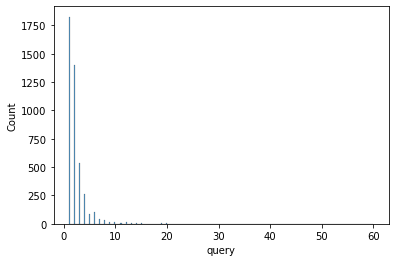

In [9]:
sns.histplot(data = final_df.groupby(['title']).count(), x = ('query'))

In [63]:
len(final_df.groupby(['title']).count())

2471

In [23]:
from pymed import PubMed

pubmed = PubMed(tool="MyTool", email="my@email.address")
results = pubmed.query("'Cognitive aging is associated with redistribution of synaptic weights in the hippocampus'", max_results=1)
for i in results:
    PMID = i.pubmed_id
    PMID = PMID[0:8]
    print(PMID)
    
    print(i.publication_date)
    
    authors = i.authors
    # Extracting the first author's lastname
    first_author_lastname = authors[0]['lastname']

    # Creating the "et al" part
    et_al = "et al"

    # Printing the formatted string
    print(f"{first_author_lastname} {et_al}. {i.journal}")

33593893
2021-02-18
Buss et al. Proceedings of the National Academy of Sciences of the United States of America
